In [1]:
import torch
import os
import torch.nn as nn
import torch.utils.data as data
from PIL import Image
from PIL import ImageFile
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger
from sampler import InfiniteSamplerWrapper
from function import calc_mean_std

Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Disable OSError: image file is truncated

In [2]:
device = torch.device('cuda')

style_dir = "/data/chengbin/style/train/"
style_paths = [os.path.join(style_dir, f) for f in os.listdir(style_dir)]

In [3]:
batch_size = 32
n_threads = 16

In [4]:
class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)

style_tf = train_transform()
style_dataset = FlatFolderDataset(style_dir, style_tf)
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=n_threads))

In [5]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

In [6]:
decoder_path = "/home/chengbin/naiqi/stylize-datasets/models/decoder.pth"
vgg_path = "/home/chengbin/naiqi/stylize-datasets/models/vgg_normalised.pth"

decoder.eval()
vgg.eval()

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))
vgg = nn.Sequential(*list(vgg.children())[:31])

vgg.to(device)
decoder.to(device)

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=nearest)
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode=nearest)
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64, 64, 

In [7]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 960*2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 960*2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [9]:
class SimNet(nn.Module):
    def __init__(self, encoder, decoder, device = torch.device('cuda')):
        super(SimNet, self).__init__()
        enc_layers = list(encoder.children())
        self.device = device;
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def adain(self, content_feat, style_mean, style_std):
        size = content_feat.size()
        content_mean, content_std = calc_mean_std(content_feat)
        normalized_feat = (content_feat - content_mean.expand(
            size)) / content_std.expand(size)
        return normalized_feat * style_std.expand(size) + style_mean.expand(size)

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]
    
    def get_feats(self, input):
        fs = self.encode_with_intermediate(input)
        mu = []
        sig = []
        for f in fs:
            mean, std = calc_mean_std(f)
            size = mean.size()
            N, C = size[:2]
            mu.append(mean.view(N, C))
            sig.append(std.view(N, C))
        all_mu = torch.cat(mu, dim=1)
        all_sig = torch.cat(sig, dim=1)
        res = torch.cat([all_mu, all_sig], dim=1)
        return res

    # extract relu4_1 from input image
    def encode(self, input):
        self.N = input.size()[0]
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target_mean, target_std):
        input_mean, input_std = calc_mean_std(input)
        # target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, alpha=1.0):
        assert 0 <= alpha <= 1
        #style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        style_mean, style_std = self.simulate()
        t = self.adain(content_feat, style_mean[-1], style_std[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_mean[0], style_std[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_mean[i], style_std[i])
        return loss_c, loss_s


network = SimNet(vgg, decoder)

In [10]:
def noise(size, device = torch.device('cuda')):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n.to(device)

In [11]:
discriminator.to(device)
generator.to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [12]:
def ones_target(size, device = torch.device('cuda')):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def zeros_target(size, device = torch.device('cuda')):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [13]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [14]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [15]:
def adain(content_feat, style_mean, style_std):
    size = content_feat.size()
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

def style_transfer(vgg, decoder, content, style_mean, style_std, alpha=1.0,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    t = adain(content_f, style_mean[-1], style_std[-1])
    feat = alpha * t + (1 - alpha) * content_f
    return decoder(feat)

In [16]:
def split_feat(fs):
    idx = [0, 64, 192, 448, 960]
    N = fs.size()[0]
    m1, m2, m3, m4 = [fs[:, idx[k]:idx[k+1]].view(N, -1, 1, 1) for k in range(4)]
    s1, s2, s3, s4 = [fs[:, idx[k]+960:idx[k+1]+960].view(N, -1, 1, 1) for k in range(4)]
    return [m1, m2, m3, m4], [s1, s2, s3, s4]

In [17]:
content_path = './example/1.JPEG' 
content_tf = train_transform()
content = content_tf(Image.open(content_path))
content = content.to(device).unsqueeze(0)

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [19]:
def images_to_vectors(images):
    return images.view(images.size(0), -1)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 256, 256)

In [ ]:
%%capture out

# Create logger instance
logger = Logger(model_name='VGAN', data_name='Style')
# Total number of epochs to train
max_iter = 15000
for i in range(max_iter):
    #real_batch = next(style_iter).to(device)
    style_image = next(style_iter).to(device)
    N = style_image.size(0)
    real_batch = network.get_feats(style_image)
    # 1. Train Discriminator
    real_data = Variable(images_to_vectors(real_batch)).to(device)
    # Generate fake data and detach 
    # (so gradients are not calculated for generator)
    fake_data = generator(noise(N).to(device)).detach()
    # Train D
    d_error, d_pred_real, d_pred_fake = \
          train_discriminator(d_optimizer, real_data, fake_data)

    # 2. Train Generator
    # Generate fake data
    fake_data = generator(noise(N))
    # Train G
    g_error = train_generator(g_optimizer, fake_data)
    # Log batch error
    logger.log(d_error, g_error, i, 0, 0)
    # Display Progress every few batches
    if (i) % 500 == 0: 
        #test_images = vectors_to_images(generator(test_noise))
        #test_images = test_images.data.cpu()num_test_samples = 1
        test_noise = noise(1)
        test_feats = generator(test_noise)       
        style_mean, style_std = split_feat(test_feats)
        
        with torch.no_grad():
            test_images = style_transfer(vgg, decoder, content, style_mean, style_std)
        test_images = vectors_to_images(test_images)
        test_images = test_images.data.cpu()
        logger.log_images(
            test_images, 1, 
            i, 0, 0
        );
        # Display status Logs
        logger.display_status(
            i, max_iter, 0, 0,
            d_error, g_error, d_pred_real, d_pred_fake
        )

Epoch: [0/15000], Batch Num: [0/0]
Discriminator Loss: 1.3189, Generator Loss: 1.1711
D(x): 0.7514, D(G(z)): 0.5774
Epoch: [500/15000], Batch Num: [0/0]
Discriminator Loss: 0.5394, Generator Loss: 2.8156
D(x): 0.9087, D(G(z)): 0.2935
Epoch: [1000/15000], Batch Num: [0/0]
Discriminator Loss: 0.3868, Generator Loss: 2.3493
D(x): 0.9295, D(G(z)): 0.2349
Epoch: [1500/15000], Batch Num: [0/0]
Discriminator Loss: 0.2222, Generator Loss: 3.9895
D(x): 0.9479, D(G(z)): 0.1259
Epoch: [2000/15000], Batch Num: [0/0]
Discriminator Loss: 0.3358, Generator Loss: 7.2667
D(x): 0.8706, D(G(z)): 0.0153
Epoch: [2500/15000], Batch Num: [0/0]
Discriminator Loss: 0.2195, Generator Loss: 3.8467
D(x): 0.9427, D(G(z)): 0.0285
Epoch: [3000/15000], Batch Num: [0/0]
Discriminator Loss: 0.0583, Generator Loss: 4.2092
D(x): 0.9818, D(G(z)): 0.0341
Epoch: [3500/15000], Batch Num: [0/0]
Discriminator Loss: 0.2137, Generator Loss: 5.0597
D(x): 0.9351, D(G(z)): 0.0346
Epoch: [4000/15000], Batch Num: [0/0]
Discriminator 

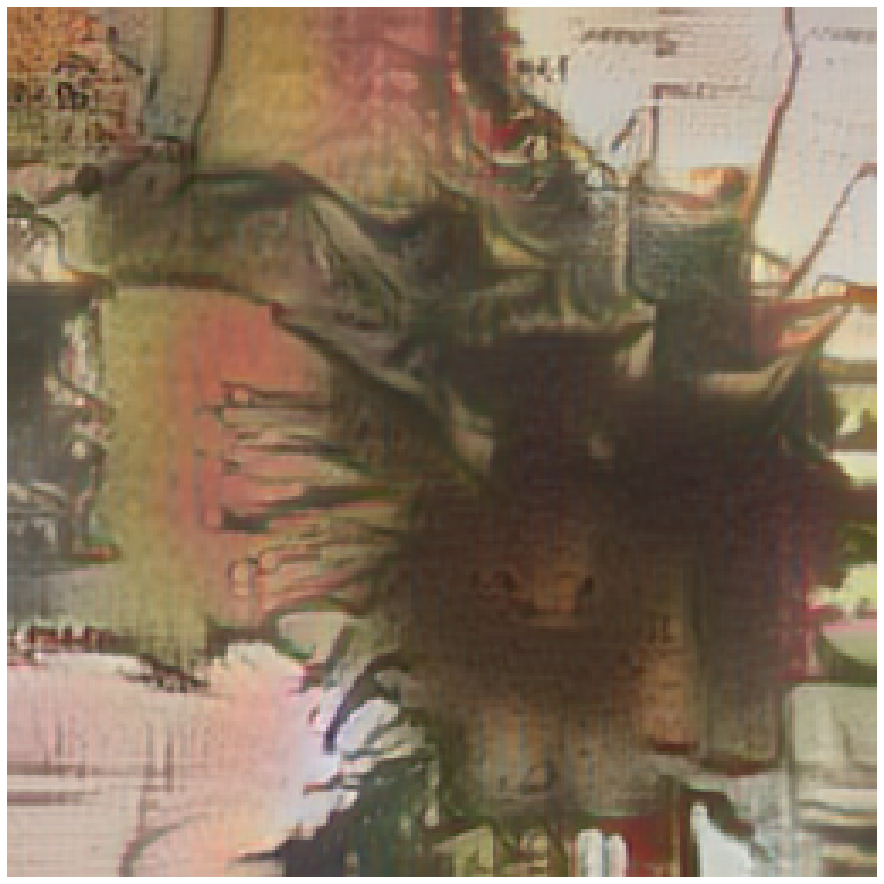

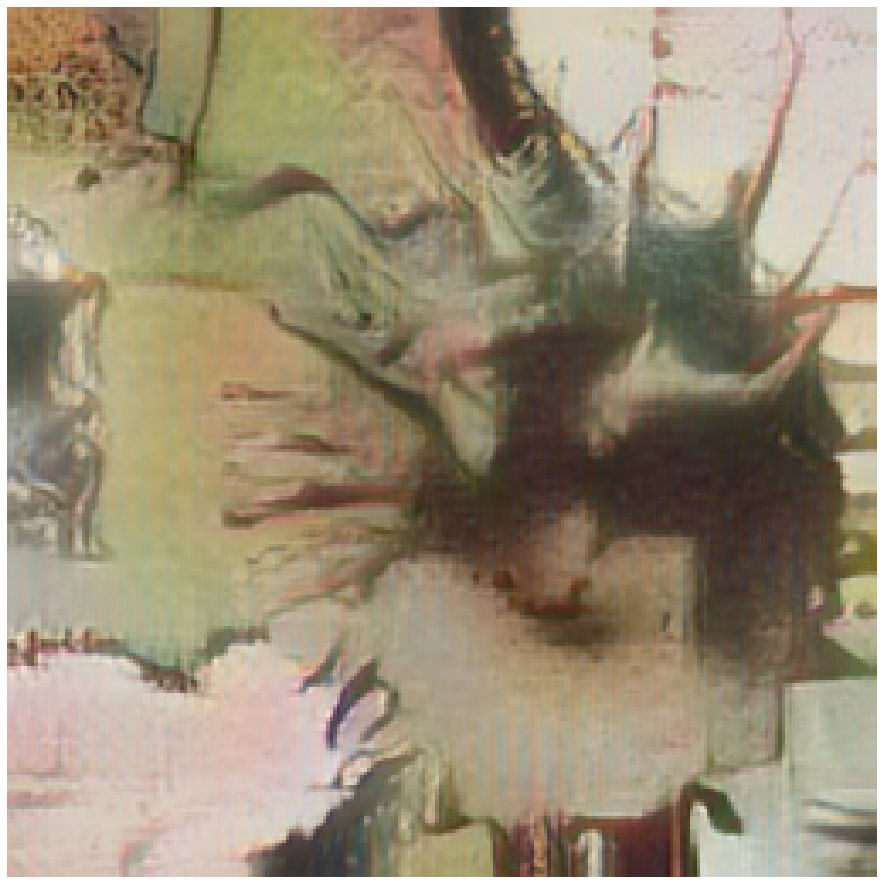

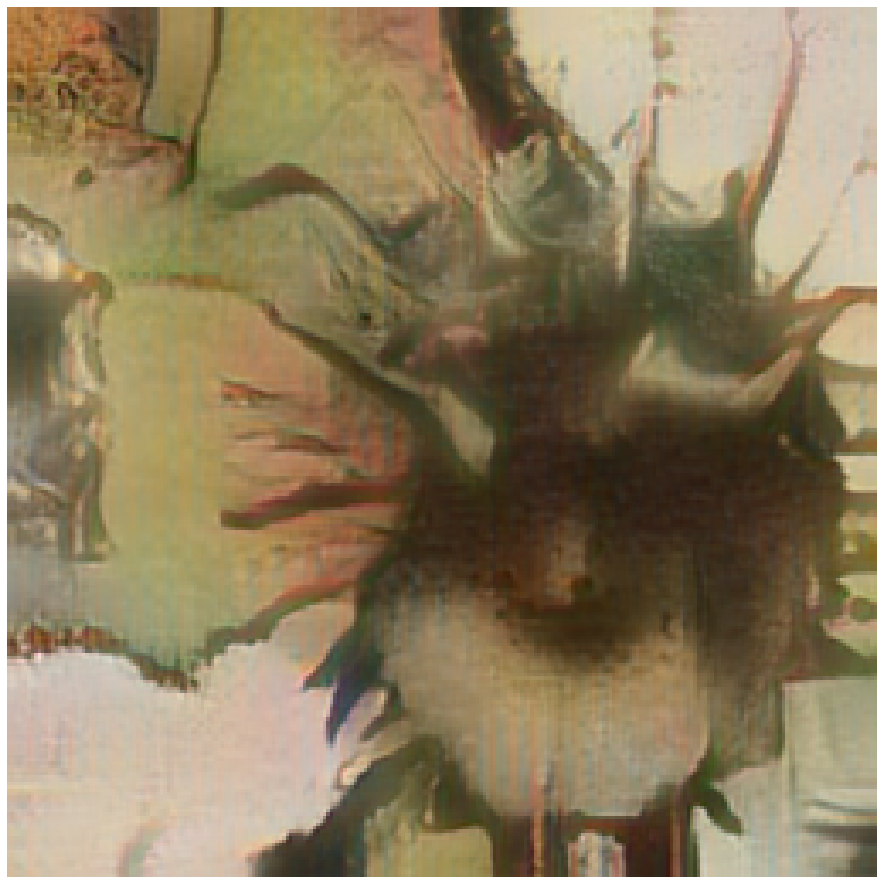

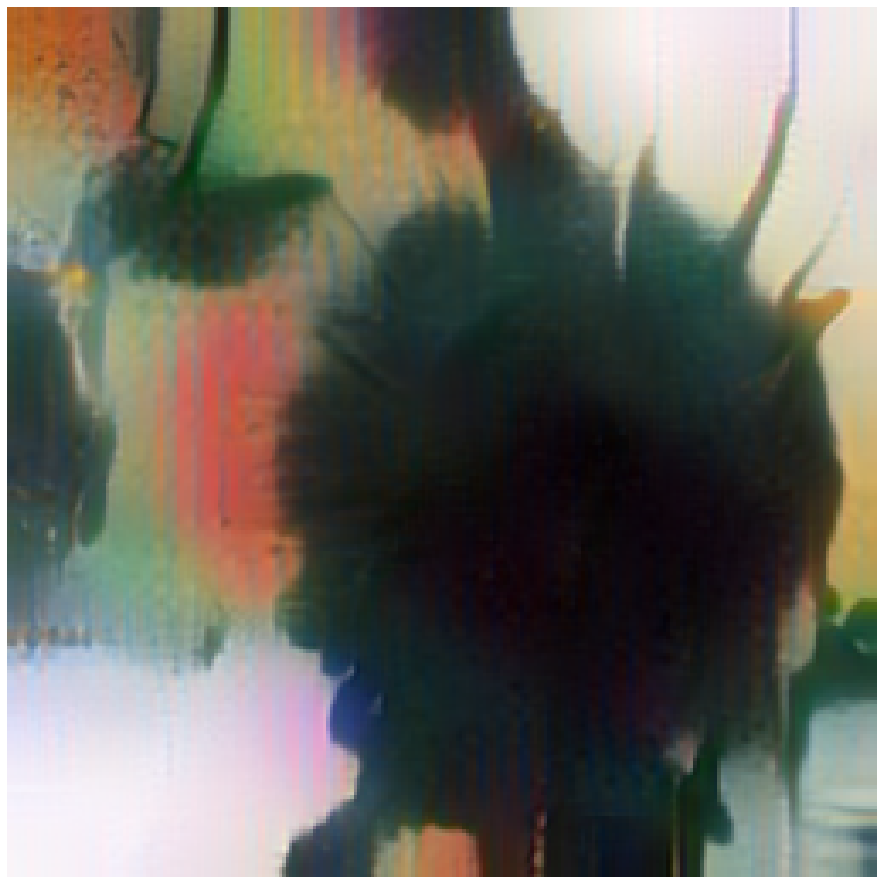

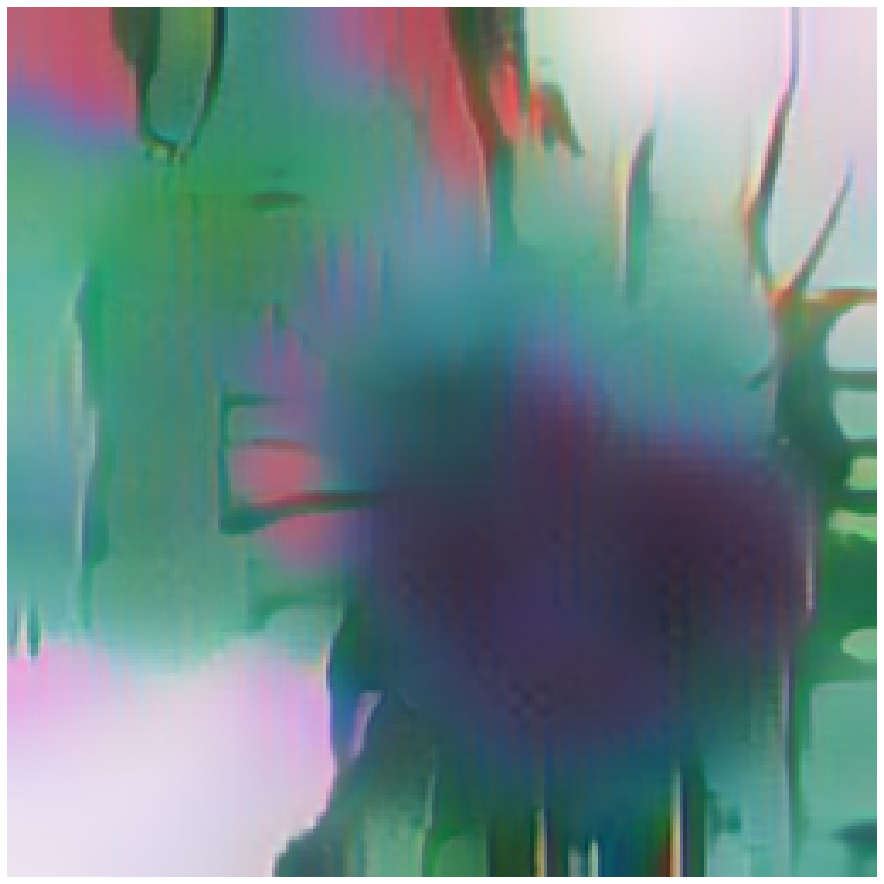

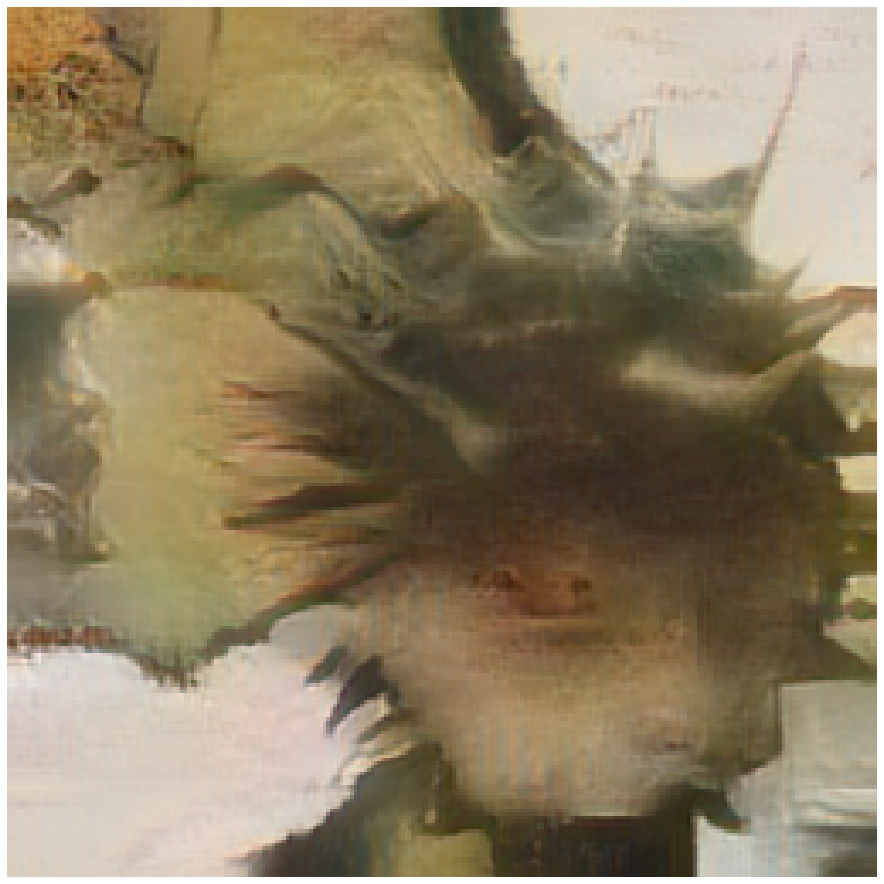

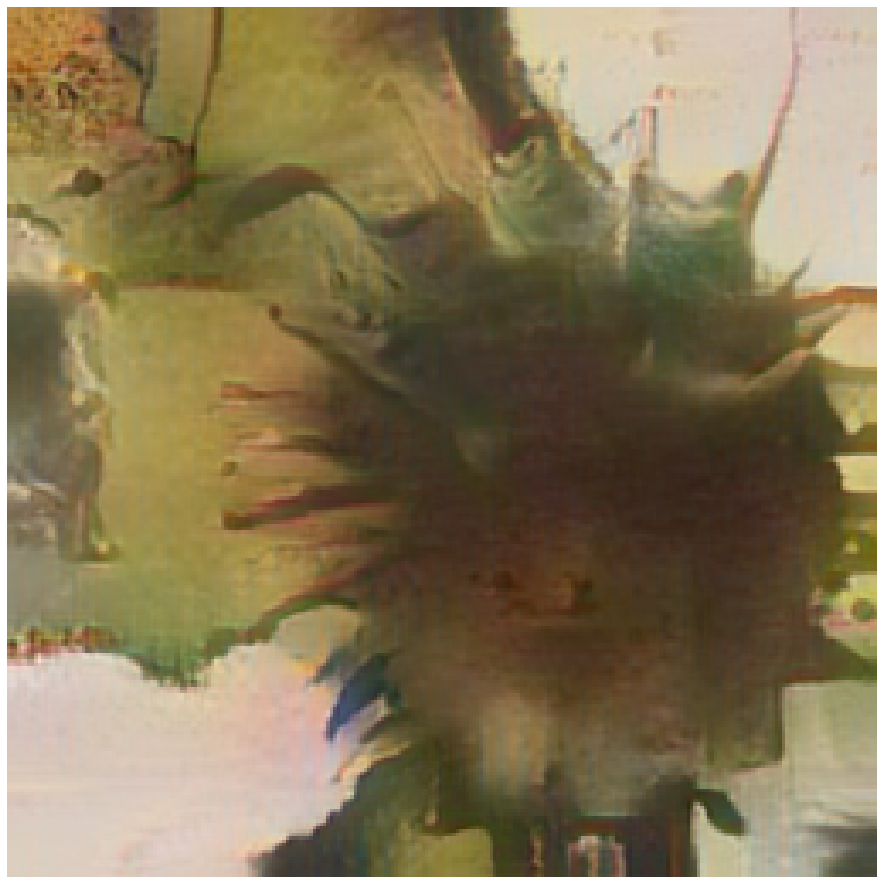

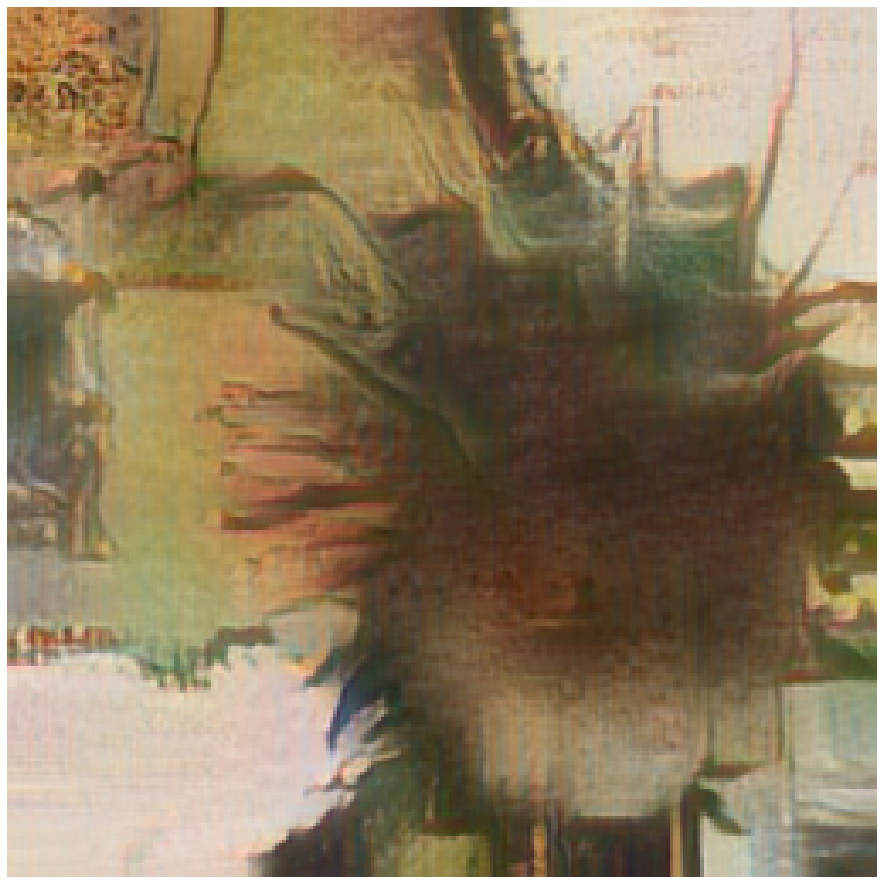

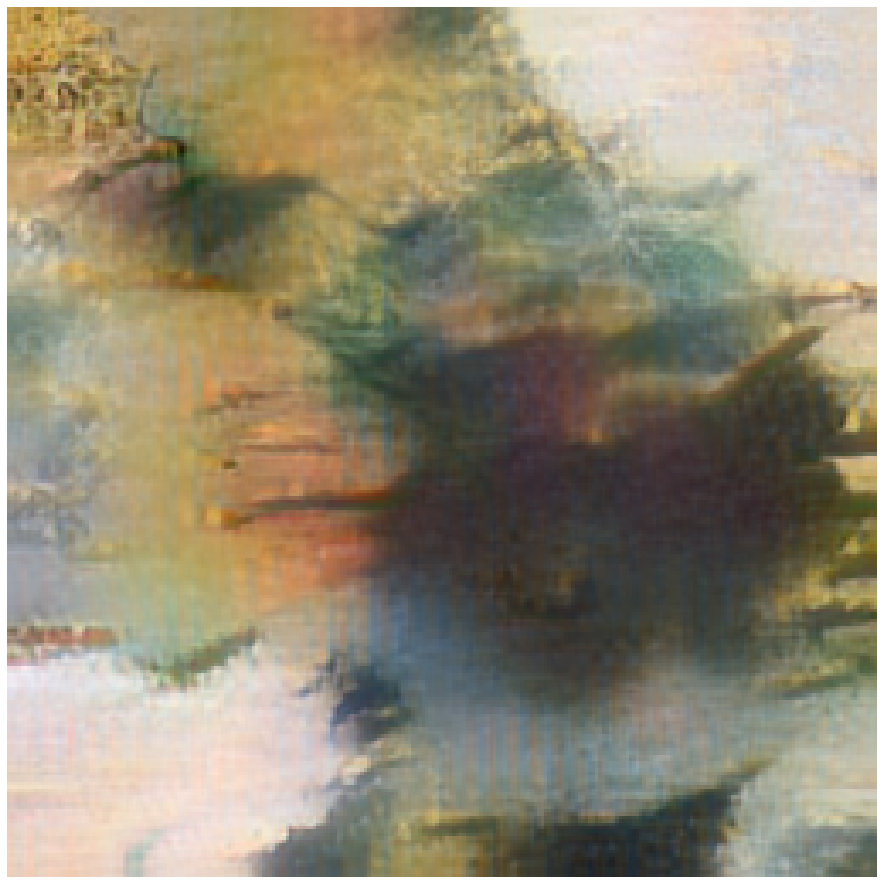

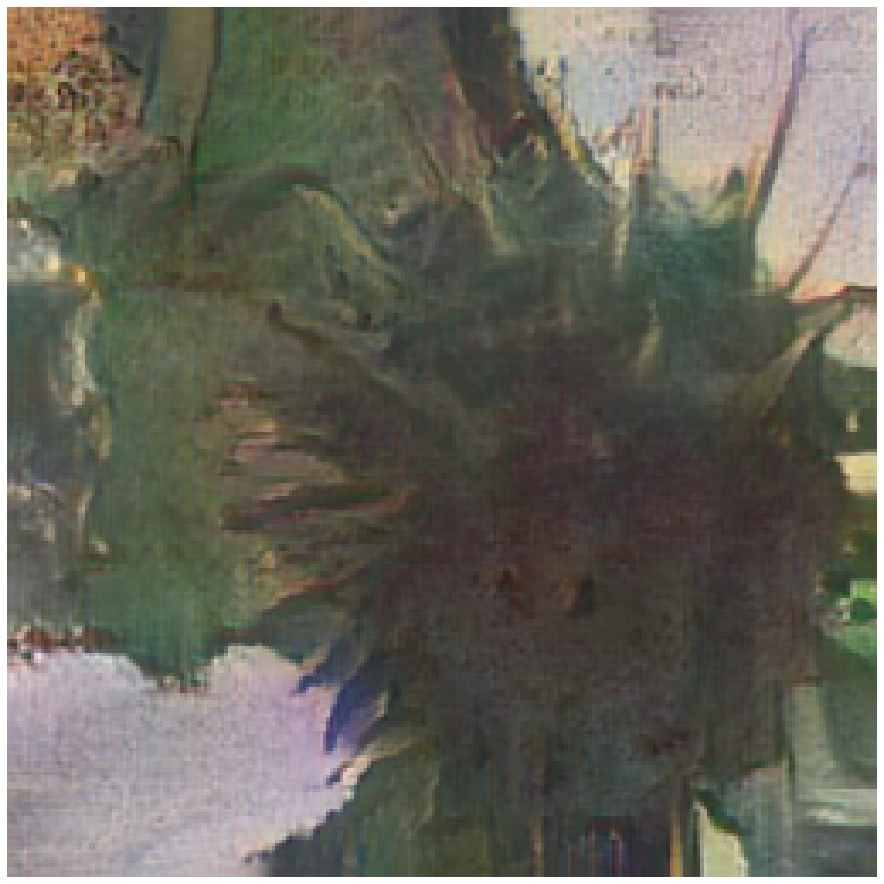

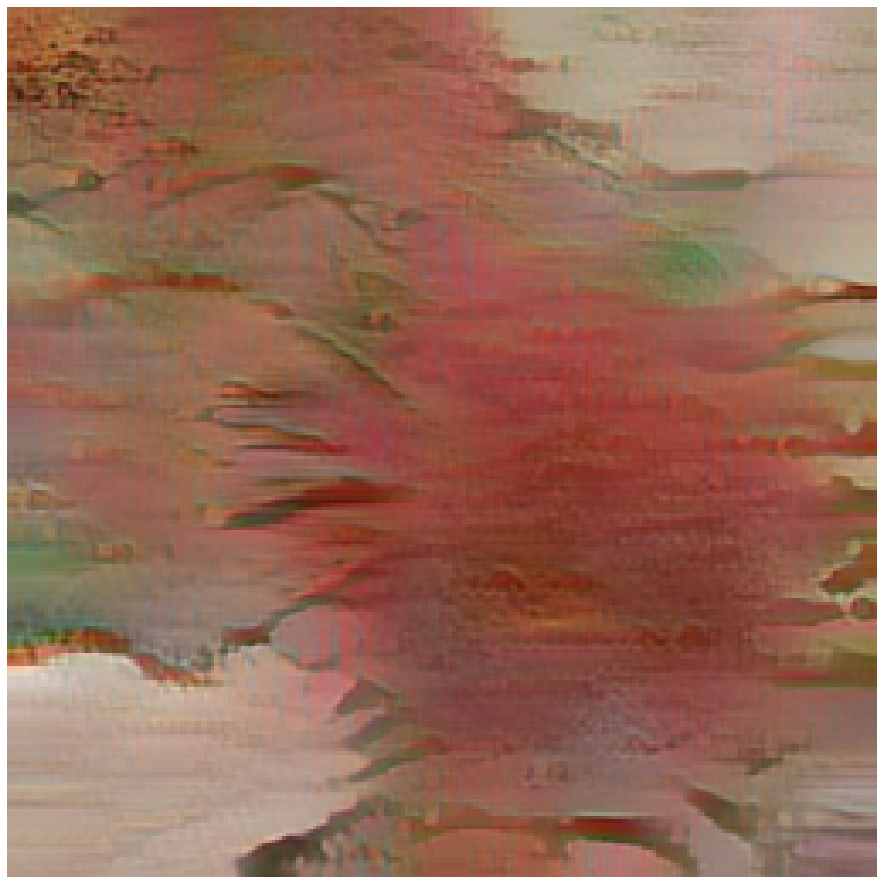

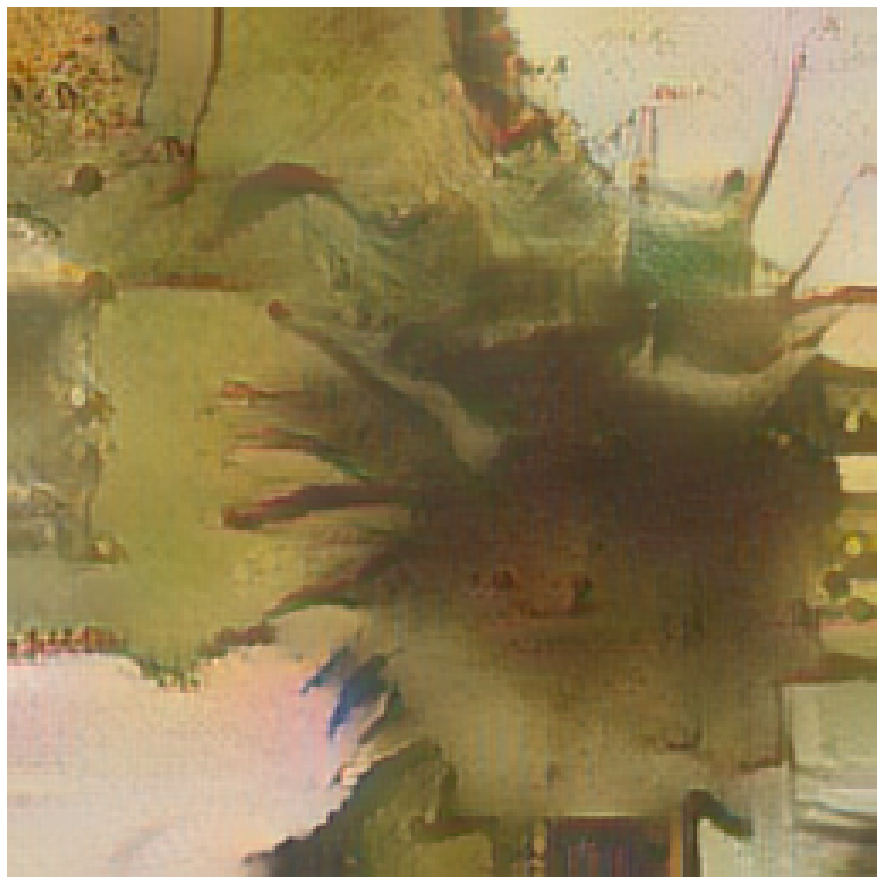

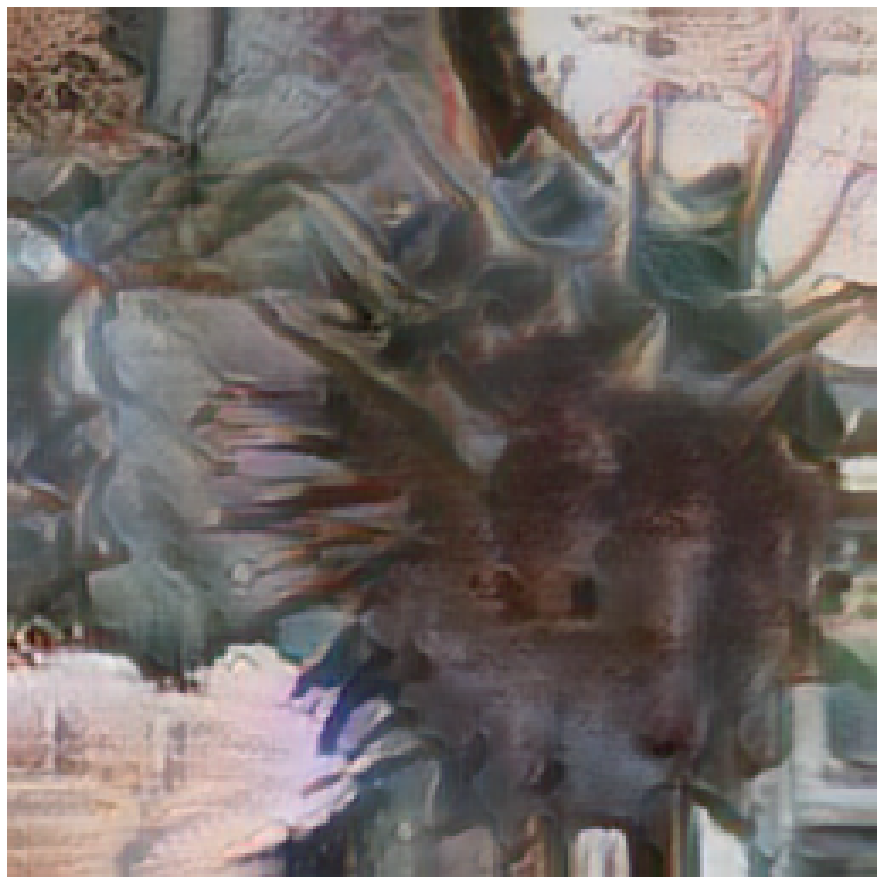

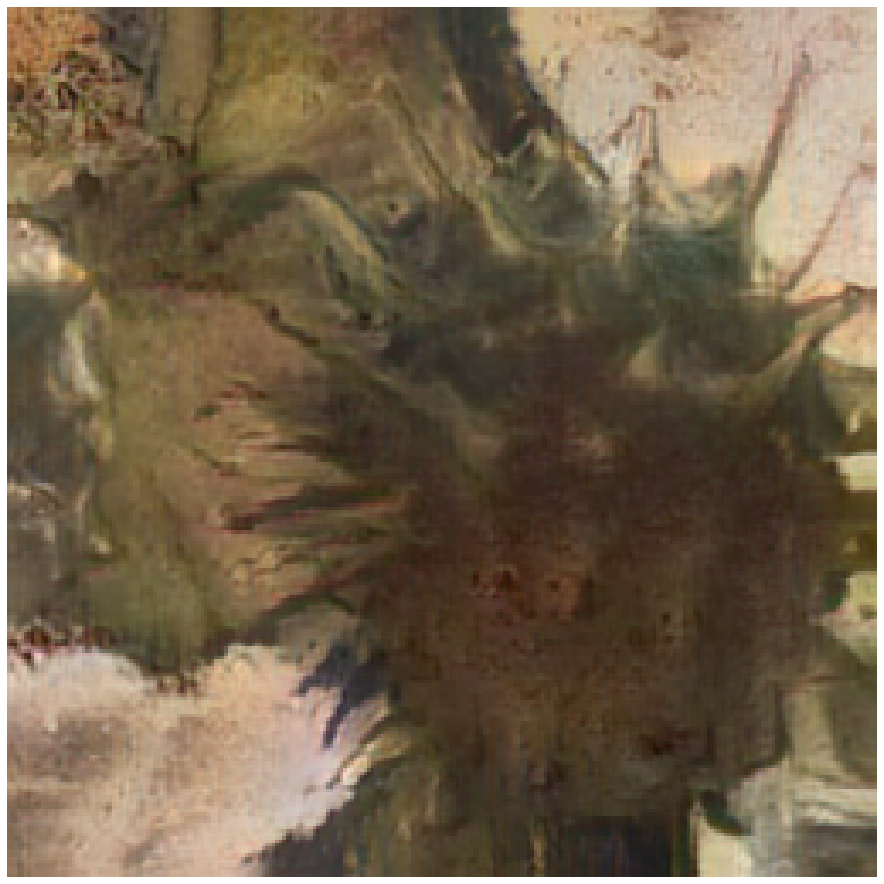

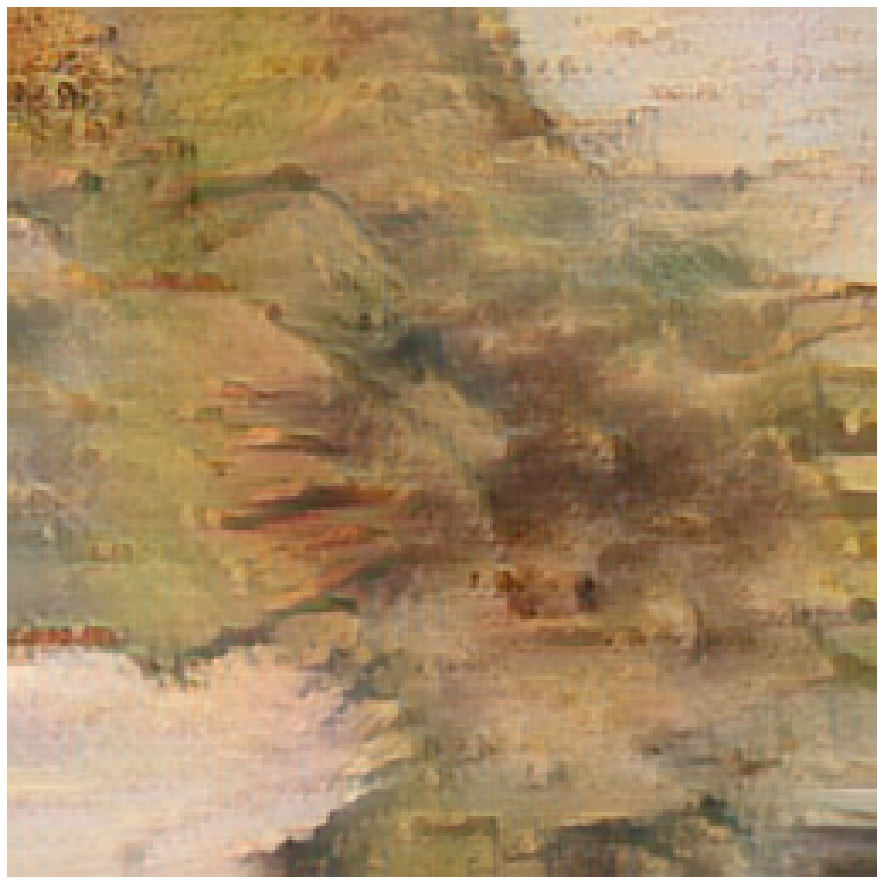

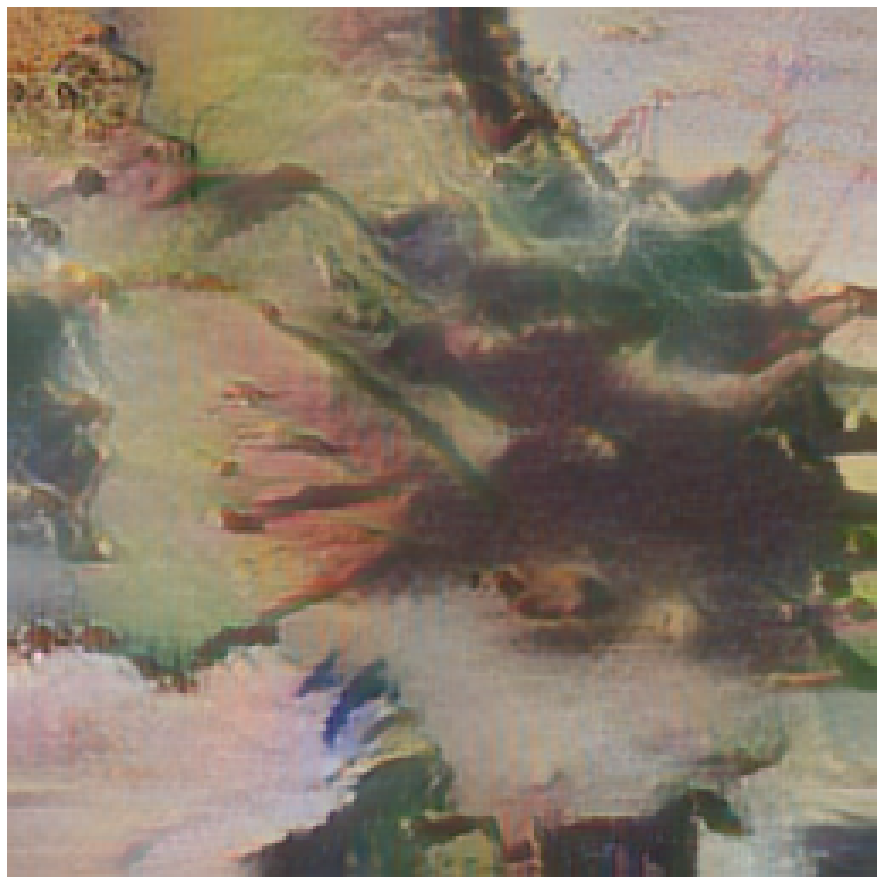

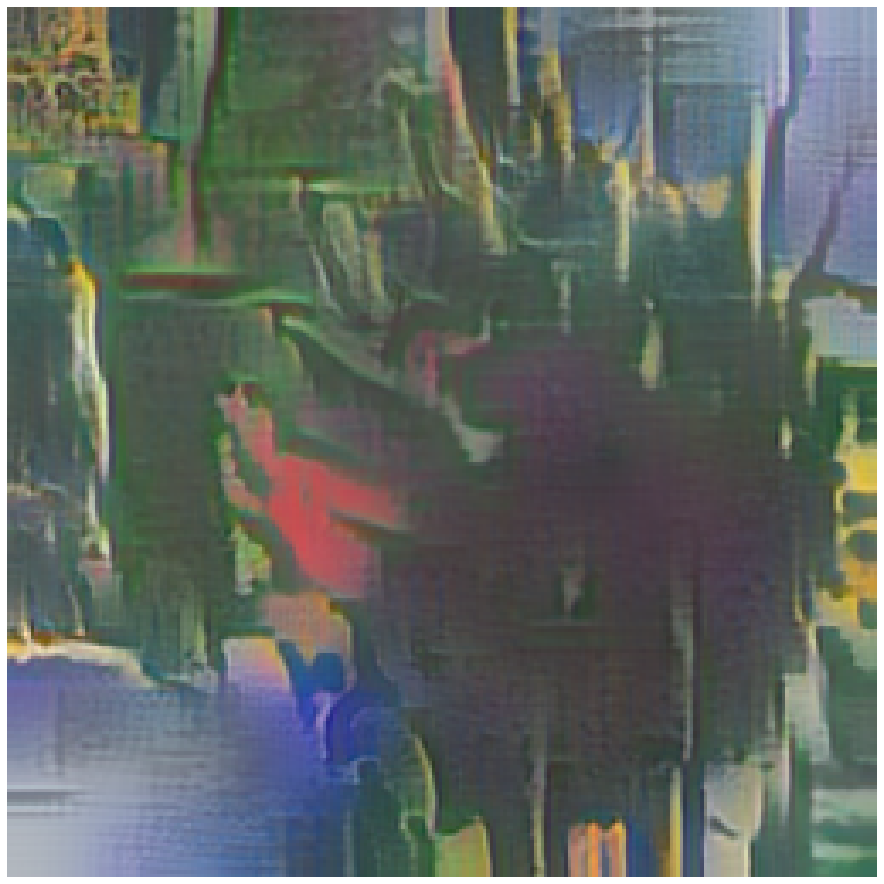

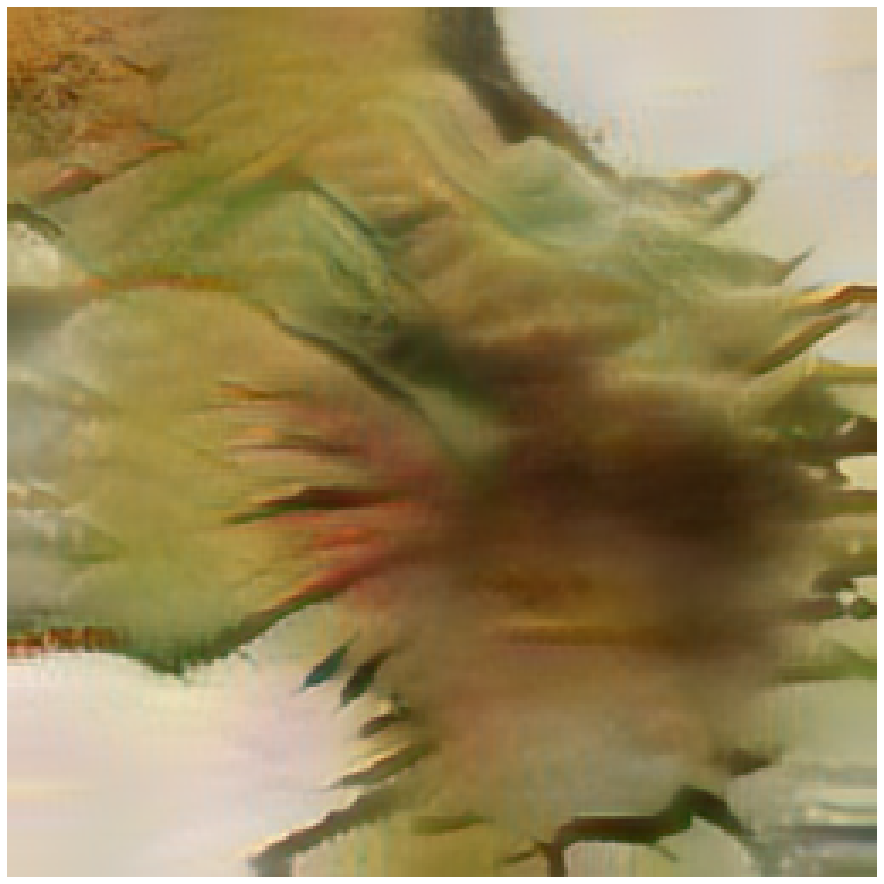

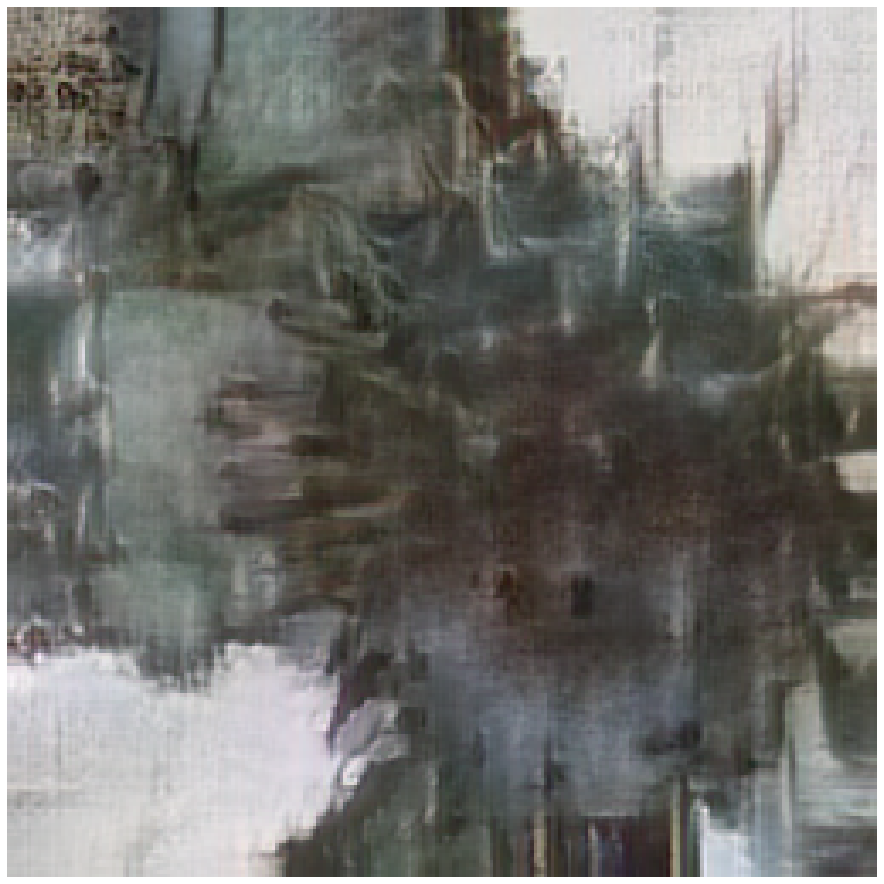

In [26]:
out.show()

In [27]:
torch.save(generator.state_dict(), './models/g_model')
torch.save(discriminator.state_dict(), './models/d_model')